<a href="https://colab.research.google.com/github/quanmtran/Sudoku-image-solver/blob/main/Sudoku_image_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
from tensorflow.keras.models import load_model

# **Step 1: Convert image of puzzle into arrays of digits**

## **Step 1.1: Read image**

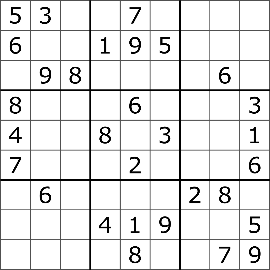

In [2]:
puz_img_ori = io.imread('https://raw.githubusercontent.com/quanmtran/Sudoku-image-solver/main/sudoku.png') 

# Resize
width = height = 270
puz_img_ori = cv2.resize(puz_img_ori, (width, height))

# Convert to gray
puz_img_gray = cv2.cvtColor(puz_img_ori, cv2.COLOR_BGR2GRAY)
cv2_imshow(puz_img_gray)

## **Step 1.2: Split image into 81 boxes**

In [3]:
def split_image(img):
    
    boxes = []
    
    # Split image into 9 rows
    rows = np.vsplit(img, 9)
    
    # Split each row into 9 boxes
    for row in rows:
        boxes_in_one_row = np.hsplit(row, 9)
        boxes.extend(boxes_in_one_row)
    
    return boxes


boxes = split_image(puz_img_gray)

In [4]:
# Check first box
cv2_imshow(boxes[0])

## **Step 1.3: Detect digits in boxes**

In [5]:
digit_detector = load_model('/content/drive/MyDrive/models/digit_detector_model.h5')

In [6]:
# Image pre-processing
def preprocess_image(img):
  img = img[4:img.shape[0] - 4, 4:img.shape[1] - 4]
  img = cv2.resize(img, (28, 28))
  img = img / 255
  img = img.reshape(1, 28, 28, 1)
  return img


# Detect digits
digits = []

for box in boxes:
  
  # Pre-process
  box = preprocess_image(box)
  
  # Predict
  pred = digit_detector.predict(box)

  pred_digit = np.argmax(pred, axis=-1) # Predicted digit
  prob = np.amax(pred) # Probability
  
  if prob >= 0.8:
    digits.extend(pred_digit)
  else:
    digits.append(0)

puz_arr = np.reshape(digits, (9, 9))
print(puz_arr)

[[5 3 0 0 7 0 0 0 0]
 [6 0 0 1 9 5 0 0 0]
 [0 9 8 0 0 0 0 6 0]
 [8 0 0 0 6 0 0 0 3]
 [4 0 0 8 0 3 0 0 1]
 [7 0 0 0 2 0 0 0 6]
 [0 6 0 0 0 0 2 8 0]
 [0 0 0 4 1 9 0 0 5]
 [0 0 0 0 8 0 0 7 9]]


# **Step 2: Solve puzzle**

In [7]:
# Function that finds empty boxes in a puzzle
def find_empty(puzzle):
    for row in range(9):
        for col in range(9):
            if puzzle[row][col] == 0:
                return (row, col)

    return None


# Function that checks if a number is valid in a given position
def is_valid(puzzle, num, pos):
    row, col = pos
    
    # Check row
    for i in range(9):
        if puzzle[row][i] == num:
            return False

    # Check column
    for i in range(9):
        if puzzle[i][col] == num:
            return False

    # Check box
    box_row = (row // 3) * 3
    box_col = (col // 3) * 3

    for i in range(box_row, box_row + 3):
        for j in range(box_col, box_col + 3):
            if puzzle[i][j] == num:
                return False

    return True


# Function that solves a puzzle
def solve(puzzle):
    find = find_empty(puzzle) # Find the first empty box
    if not find:
        return True
    else:
        row, col = find # Position of the empty box

    for num in range(1,10): # Loop through numbers from 1 to 9
        if is_valid(puzzle, num, (row, col)):
            puzzle[row][col] = num

            if solve(puzzle):
                return True

            puzzle[row][col] = 0

    return False


solve(puz_arr)
print(puz_arr)

[[5 3 4 6 7 8 9 1 2]
 [6 7 2 1 9 5 3 4 8]
 [1 9 8 3 4 2 5 6 7]
 [8 5 9 7 6 1 4 2 3]
 [4 2 6 8 5 3 7 9 1]
 [7 1 3 9 2 4 8 5 6]
 [9 6 1 5 3 7 2 8 4]
 [2 8 7 4 1 9 6 3 5]
 [3 4 5 2 8 6 1 7 9]]


# **Step 3: Show solution**

## **Step 3.1: Extract digits filled by the solver**

In [8]:
# Mark position of blanks as 1, otherwise 0
blank_pos = [0 if num > 0 else 1 for num in digits]
blank_pos = np.reshape(blank_pos, (9, 9))

# Extract filled digits
puz_arr_filled = puz_arr * blank_pos
print(puz_arr_filled)

[[0 0 4 6 0 8 9 1 2]
 [0 7 2 0 0 0 3 4 8]
 [1 0 0 3 4 2 5 0 7]
 [0 5 9 7 0 1 4 2 0]
 [0 2 6 0 5 0 7 9 0]
 [0 1 3 9 0 4 8 5 0]
 [9 0 1 5 3 7 0 0 4]
 [2 8 7 0 0 0 6 3 0]
 [3 4 5 2 0 6 1 0 0]]


## **Step 3.2: Overlay filled digits on image**

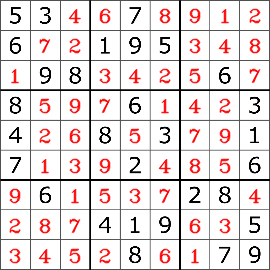

In [9]:
puz_img_solved = cv2.cvtColor(puz_img_gray, cv2.COLOR_GRAY2BGR)

# Size of each box
box_width = width / 9
box_height = height / 9

# Settings
fontFace = cv2.FONT_HERSHEY_COMPLEX_SMALL
fontScale = 1
thickness = 1

for row in range(9):
  for col in range(9):
    if puz_arr_filled[row][col] != 0:
      
      digit = str(puz_arr_filled[row][col])
      
      # Extract text size, i.e., width and height
      text_size = cv2.getTextSize(digit, fontFace, fontScale, thickness)[0]

      text_width = text_size[0]
      text_height = text_size[1]

      # Find text coordinates
      text_x = int(col * box_width + (box_width - text_width) // 2)
      text_y = int(row * box_height + (box_height + text_height) // 2)

      # Put text on image
      cv2.putText(img = puz_img_solved,
                  text = digit,
                  org = (text_x, text_y),
                  fontFace = fontFace,
                  fontScale = fontScale,
                  color = (0, 0, 255),
                  thickness = thickness,
                  lineType = cv2.LINE_AA
                  )
      
cv2_imshow(puz_img_solved)